In [1]:
# current ADAM resnet18 with 200 epochs is 76% accuracy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
from numpy import asarray
import PIL.Image as Image
import torch.nn as nn
import tqdm
import gc

device = "cuda"

torch.cuda.empty_cache()
gc.collect()
        
import torchvision.transforms as transforms
transform = transforms.ToTensor()

In [2]:
patch_size = 16

# get dataset stuffs
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.utils import load_state_dict_from_url

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataset = torchvision.datasets.CIFAR100(root="based", train=False, download=True, transform=transform)

val_dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


dataset = torchvision.datasets.CIFAR100(root="based", train=True, download=True, transform=transform)

train_dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

0it [00:00, ?it/s]

Extracting based/cifar-100-python.tar.gz to based
Files already downloaded and verified


In [3]:
!pip install vit-pytorch

In [4]:
def testb():
    acc = 0
    total = 0
    for n_, (x, y) in enumerate(val_dataloader):
        x = x.to(device)
        bs = x.shape[0]
        x = x.reshape(bs, 3, 32, 32)
        
        y_hat = v(x) # add encodings?
        for _, i in enumerate(y_hat):
            if i.argmax() == y.to(device)[_]:
                acc +=1
            total +=1
            
    return acc/total

In [5]:

import torch
from vit_pytorch import ViT

# get ViT-B/16 model
"""
# ViT-L/8
v = ViT(
    image_size = 32,
    patch_size = 8,
    num_classes = 10,
    dim = 1024,
    depth = 24,
    heads = 16,
    mlp_dim = 4096,
    dropout = 0.1,
    emb_dropout = 0.1
)
"""
# ViT-L/24
v = ViT(
    image_size = 32,
    patch_size = patch_size,
    num_classes = 100,
    dim = 1024,
    depth = 24,
    heads = 16,
    mlp_dim = 4096,
    dropout = 0.1,
    emb_dropout = 0.1
)

#from pytorch_pretrained_vit import ViT
#v = ViT('B_16_imagenet1k', pretrained=True)

v.eval()

# initialize stuffs
losslist_n = []
v = v.to(device)
voptimizer = torch.optim.Adam(v.parameters(), lr=.0001)
import random
import time

timelist_n = []
acc = 0
total = 0
# do loop for baseline
stime = time.time()
for epoch in range(150):
    t = tqdm.tqdm(train_dataloader, position=0, leave=True)
    tloss = 0
    # loop over data
    n = 0
    for (x, y) in t:
        n +=1
        bs = x.shape[0]
        
        # change device to gpu
        x = x.to(device)
        y = y.to(device)
        
        # forward pass
        x = x.reshape(bs, 3, 32, 32)
        f_y_hat = v(x)
        
        # backward pass
        loss = torch.nn.CrossEntropyLoss()((f_y_hat).reshape([bs, 100]), y) # nn.ReLU()
        loss.backward()
        tloss += loss
        
        # optimize
        voptimizer.step() 
        voptimizer.zero_grad()
        
        # keep track of this epoch's loss
        t.set_description_str(str(tloss.detach().cpu().numpy()/(n+1))) # 14:.2
        
    # test epoch's accuracy and append it to the list
    l = testb()
    print(l)
    losslist_n.append(l)
    timelist_n.append(time.time() - stime)
    
# 5 = 2 normal
# new 1.8 = 5

4.08654444350809: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.1217


3.623926153037754: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.1672


3.399200594364689: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.2041


3.246368872937817: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.227


3.113771700011897: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.2376


3.004231564284581: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.2583


2.8917282801594224: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]


0.2749


2.7850174492385786: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.2859


2.687508984870717: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.2973


2.5791108571938453: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.2976


2.47645824451737: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3098


2.357978317338198: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3163


2.2283481655992228: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3292


2.0916094320074556: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3229


1.9438016475154665: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3386


1.7632847510013483: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3373


1.5811476344384519: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3374


1.3621819975412437: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3357


1.1543530304419813: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3382


0.9387317018460501: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3334


0.7480619788774984: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3403


0.5727790793791641: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3417


0.4547955275792156: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3432


0.3728164053205306: 100%|██████████| 196/196 [01:45<00:00,  1.87it/s]


0.3358


0.31719848710268284: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3399


0.2703861681943012: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.338


0.2427793396305917: 100%|██████████| 196/196 [01:45<00:00,  1.87it/s]


0.3407


0.22818761912699279: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3361


0.21075245813669893: 100%|██████████| 196/196 [01:45<00:00,  1.87it/s]


0.3373


0.19272958203620716: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3367


0.18741565065335503: 100%|██████████| 196/196 [01:45<00:00,  1.85it/s]


0.3355


0.1742300430530219: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3357


0.15635725689418425: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3318


0.15461934278459114: 100%|██████████| 196/196 [01:45<00:00,  1.85it/s]


0.3293


0.15203216475278594: 100%|██████████| 196/196 [01:45<00:00,  1.85it/s]


0.3409


0.14846484189106124: 100%|██████████| 196/196 [01:45<00:00,  1.85it/s]


0.3369


0.14897178998453364: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3338


0.1449160406432176: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3353


0.13507509957715338: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3352


0.11388617965775698: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3294


0.12407070489099183: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3375


0.1253137927370023: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.334


0.13063602157050583: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3373


0.1067304562796191: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3364


0.11394557856061131: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3347


0.11154199977816665: 100%|██████████| 196/196 [01:45<00:00,  1.87it/s]


0.3378


0.10869028120476583: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3364


0.0998575723715845: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3345


0.10970506813320412: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3394


0.10758148232087265: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3352


0.10022013320535572: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3375


0.08723470039174036: 100%|██████████| 196/196 [01:45<00:00,  1.87it/s]


0.3354


0.1078636634168286: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3413


0.08954469322553141: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3383


0.09549177721672251: 100%|██████████| 196/196 [01:46<00:00,  1.84it/s]


0.3276


0.0938948616763662: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3327


0.09565171372466887: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3354


0.0872279617387026: 100%|██████████| 196/196 [01:46<00:00,  1.85it/s]


0.3342


0.099929354517593: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3392


0.08750603767821026: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3336


0.08504866585513662: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3371


0.07797261058981649: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3381


0.07778422360492841: 100%|██████████| 196/196 [01:46<00:00,  1.85it/s]


0.3366


0.07767552409680362: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3331


0.08051481585817288: 100%|██████████| 196/196 [01:46<00:00,  1.84it/s]


0.335


0.08123614703338158: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3322


0.07827689562957299: 100%|██████████| 196/196 [01:46<00:00,  1.85it/s]


0.3303


0.07580665162372105: 100%|██████████| 196/196 [01:45<00:00,  1.87it/s]


0.3319


0.07404935904565801: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3348


0.07204611531368972: 100%|██████████| 196/196 [01:45<00:00,  1.85it/s]


0.3376


0.0687220907453353: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.332


0.0737183130332056: 100%|██████████| 196/196 [01:46<00:00,  1.85it/s]


0.3313


0.07664849431381612: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3351


0.05730995429953948: 100%|██████████| 196/196 [01:45<00:00,  1.85it/s]


0.3301


0.06537337714645464: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3293


0.07494688760205574: 100%|██████████| 196/196 [01:46<00:00,  1.85it/s]


0.3302


0.0733763263915396: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3324


0.07453598951930322: 100%|██████████| 196/196 [01:45<00:00,  1.87it/s]


0.3356


0.05698729771647962: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3351


0.057376077332472436: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.336


0.07145587320860267: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3266


0.06994747026317616: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3316


0.06783248204265149: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3349


0.0661803405296984: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3349


0.05895490694772169: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3351


0.05594605479748721: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3349


0.06100744160298768: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3357


0.05338045788295378: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3343


0.06466455992103227: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3365


0.05928224960559516: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.337


0.0592364635564349: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3293


0.05889719754911316: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3346


0.06188151558038547: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3314


0.061855572734387396: 100%|██████████| 196/196 [01:42<00:00,  1.90it/s]


0.3353


0.052015933893658786: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.331


0.05657153444241751: 100%|██████████| 196/196 [01:45<00:00,  1.87it/s]


0.3344


0.05763972229158818: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3307


0.05289570571202312: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3319


0.054234059328960284: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.3332


0.05931908467094305: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]


0.3324


0.054824649985066524: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3371


0.054361314337870795: 100%|██████████| 196/196 [01:45<00:00,  1.87it/s]


0.3369


0.047796297799512215: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3325


0.04625611377851612: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3368


0.04655870931402681: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3373


0.051618464707118: 100%|██████████| 196/196 [01:45<00:00,  1.87it/s]


0.3308


0.0534740680365393: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3381


0.05509584204194509: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3301


0.05298996455778325: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3386


0.04438158219235803: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.3363


0.04149833427467927: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3363


0.03937668727739208: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3325


0.052997008192962804: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3357


0.05417756985891894: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3305


0.055318077203586016: 100%|██████████| 196/196 [01:42<00:00,  1.90it/s]


0.3354


0.044256258737012215: 100%|██████████| 196/196 [01:45<00:00,  1.85it/s]


0.3406


0.04550598841633288: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3396


0.039563776877930924: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3334


0.044802651187490085: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3364


0.04966277398433782: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3336


0.04647405014425365: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3354


0.04282797895712296: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3365


0.04881652115565266: 100%|██████████| 196/196 [01:45<00:00,  1.87it/s]


0.3344


0.05232124522252737: 100%|██████████| 196/196 [01:42<00:00,  1.92it/s]


0.3368


0.04419788128228357: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3362


0.04219058564471714: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3427


0.042247413983804924: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3349


0.043214158963430956: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3306


0.03798770662491697: 100%|██████████| 196/196 [01:42<00:00,  1.92it/s]


0.3363


0.04289115867033828: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3373


0.04048860617700567: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3381


0.04281376582111804: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3368


0.04845960007101146: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.3346


0.04277557043859801: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.334


0.03783166953149786: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3369


0.039568692899597475: 100%|██████████| 196/196 [01:45<00:00,  1.85it/s]


0.339


0.04178383144630393: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3327


0.03749265283497457: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]


0.3306


0.04387644462779089: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3343


0.03557442166478501: 100%|██████████| 196/196 [01:45<00:00,  1.85it/s]


0.34


0.0386935103363192: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3365


0.040389583800649886: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.3358


0.040837016807594884: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3354


0.040259213617005324: 100%|██████████| 196/196 [01:45<00:00,  1.85it/s]


0.3367


0.04032355516695129: 100%|██████████| 196/196 [01:45<00:00,  1.85it/s]


0.3398


0.034562490918309555: 100%|██████████| 196/196 [01:42<00:00,  1.92it/s]


0.3429


0.030363738839396366: 100%|██████████| 196/196 [01:45<00:00,  1.85it/s]


0.3369


0.033956346172971774: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3385


0.030684993956899886: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3382


0.03948268793561132: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.33


In [6]:
# load in ViT-b/16 results from the above code ran in previous version, I seperated these two in case the session was terminated and the data would be lost
#losslist_n = [0.3157, 0.3891, 0.439, 0.4689, 0.477, 0.4756, 0.5138, 0.5237, 0.5193, 0.5305, 0.5254, 0.5387, 0.538, 0.5333, 0.5338, 0.537, 0.5315, 0.5291, 0.5326, 0.5311, 0.5343, 0.5281, 0.5314, 0.5348, 0.5386, 0.5441, 0.5356, 0.5313, 0.5389, 0.5413, 0.5356, 0.5364, 0.5333, 0.5355, 0.5315, 0.5379, 0.532, 0.535, 0.5357, 0.5372, 0.5377, 0.5473, 0.5449, 0.5476, 0.537, 0.54, 0.5382, 0.5447, 0.5443, 0.5383, 0.5358, 0.5437, 0.5411, 0.5445, 0.5457, 0.5427, 0.5417, 0.5376, 0.5367, 0.5335, 0.5391, 0.5463, 0.5426, 0.5446, 0.5442, 0.5437, 0.5425, 0.5407, 0.5454, 0.5453, 0.5496, 0.5428, 0.544, 0.5299, 0.5423, 0.5399, 0.5405, 0.5388, 0.5386, 0.5387, 0.5513, 0.545, 0.5419, 0.537, 0.5384, 0.5405, 0.5462, 0.5379, 0.5495, 0.55, 0.5417, 0.5526, 0.5459, 0.5427, 0.5366, 0.5468, 0.5494, 0.5487, 0.5459, 0.5411, 0.5495, 0.5474, 0.5455, 0.5498, 0.5476, 0.5476, 0.5509, 0.5454, 0.5459, 0.539, 0.545, 0.5509, 0.5467, 0.5453, 0.5409, 0.5493, 0.5422, 0.5379, 0.5439, 0.5438, 0.5488, 0.5497, 0.545, 0.5481, 0.5501, 0.5567, 0.5476, 0.5431, 0.5437, 0.5458, 0.5469, 0.5469, 0.5483, 0.5442, 0.5466, 0.5471, 0.5525, 0.546, 0.5458, 0.5472, 0.5459, 0.5471, 0.5432, 0.5493, 0.5521, 0.5455, 0.5441, 0.5422, 0.5487, 0.5507, 0.5461, 0.5522, 0.5425, 0.5502, 0.5555, 0.5563, 0.5524, 0.5537, 0.5462, 0.5571, 0.5475, 0.5464, 0.548, 0.5335, 0.5488, 0.5503, 0.5507, 0.5481, 0.5403, 0.5444, 0.5473, 0.5435, 0.5491, 0.5421, 0.5532, 0.5531, 0.5546, 0.5551, 0.5534, 0.5484, 0.5433, 0.5558, 0.5452, 0.5509, 0.5482, 0.5452, 0.5556, 0.5527, 0.5511, 0.5469, 0.5474, 0.549, 0.547, 0.5456, 0.5508, 0.5471, 0.5571, 0.5499, 0.554, 0.5525]
print(losslist_n)
print(timelist_n)

torch.save(v.state_dict(), "v")
torch.save(voptimizer.state_dict(), "o")
#torch.save(Head.state_dict(), "H")

[0.1217, 0.1672, 0.2041, 0.227, 0.2376, 0.2583, 0.2749, 0.2859, 0.2973, 0.2976, 0.3098, 0.3163, 0.3292, 0.3229, 0.3386, 0.3373, 0.3374, 0.3357, 0.3382, 0.3334, 0.3403, 0.3417, 0.3432, 0.3358, 0.3399, 0.338, 0.3407, 0.3361, 0.3373, 0.3367, 0.3355, 0.3357, 0.3318, 0.3293, 0.3409, 0.3369, 0.3338, 0.3353, 0.3352, 0.3294, 0.3375, 0.334, 0.3373, 0.3364, 0.3347, 0.3378, 0.3364, 0.3345, 0.3394, 0.3352, 0.3375, 0.3354, 0.3413, 0.3383, 0.3276, 0.3327, 0.3354, 0.3342, 0.3392, 0.3336, 0.3371, 0.3381, 0.3366, 0.3331, 0.335, 0.3322, 0.3303, 0.3319, 0.3348, 0.3376, 0.332, 0.3313, 0.3351, 0.3301, 0.3293, 0.3302, 0.3324, 0.3356, 0.3351, 0.336, 0.3266, 0.3316, 0.3349, 0.3349, 0.3351, 0.3349, 0.3357, 0.3343, 0.3365, 0.337, 0.3293, 0.3346, 0.3314, 0.3353, 0.331, 0.3344, 0.3307, 0.3319, 0.3332, 0.3324, 0.3371, 0.3369, 0.3325, 0.3368, 0.3373, 0.3308, 0.3381, 0.3301, 0.3386, 0.3363, 0.3363, 0.3325, 0.3357, 0.3305, 0.3354, 0.3406, 0.3396, 0.3334, 0.3364, 0.3336, 0.3354, 0.3365, 0.3344, 0.3368, 0.3362, 0.3427,

In [7]:
def test(f):
    acc = 0
    total = 0
    # loop over test set
    for n_, (x, y) in enumerate(val_dataloader):
        bs = x.shape[0]
        x = x.to(device)
        
        # f is how many times ViT loops over data
        for i in range(f):
            x = v(x)
            x = x.reshape(bs, 3, 32, 32)
            
        # apply Head
        y_hat = Head(x)
        
        # loop over predicted and see if equal to the ground truth
        for _, i in enumerate(y_hat):
            if i.argmax() == y.to(device)[_]:
                acc +=1
            total +=1
            
    return acc/total

In [8]:
# blank module to replace nn.Softmaxes with
class make_linear(torch.nn.Module):
    def __init__(self):
        super(make_linear, self).__init__()

    def forward(self, x):
        return x

In [9]:
def replace_layers(model, old, new):
    # stolen from stack overflow, replaces all non linearities so that transformers are linear
    for n, module in model.named_children():
        if len(list(module.children())) > 0:
            ## compound module, go inside it
            replace_layers(module, old, new)
            
        if isinstance(module, old):
            ## simple module
            setattr(model, n, new)

In [10]:
import torch
from vit_pytorch import ViT

v = ViT(
    image_size = 32,
    patch_size = 16,
    num_classes = 10,
    dim = 768,
    depth = 16,
    heads = 8,
    mlp_dim = 1024,
    dropout = 0.1,
    emb_dropout = 0.1
)
#from pytorch_pretrained_vit import ViT
#model = ViT('B_16_imagenet1k', pretrained=True)

v.eval()
v = torch.nn.Sequential(*(list(v.children())[:-1])) # get rid of MLP dim
# MLP dim consists of Layernorm and then activationless FC
v = torch.nn.Sequential(*(list(v.children()) + [nn.BatchNorm1d(4)])) #
#replace_layers(v, nn.Softmax, make_linear())

losslist_r = []

#Head = torch.nn.Sequential(*(list([ViT(image_size=32, patch_size=32, num_classes=10, dim=768, depth=1, heads=4, mlp_dim=3072)]))) # might want to increase head size bc the ViT is just interpresting patterns this actually makes decision
Head = torch.nn.Sequential(*(list([nn.Flatten(), nn.LayerNorm(3072), nn.Linear(3072, 100)])))


v = v.to(device)
Head = Head.to(device)

voptimizer = torch.optim.Adam(v.parameters(), lr=.0001)
hoptimizer = torch.optim.Adam(Head.parameters(), lr=.0001)
import random
import time

timelist_r = []

loops = 2 # might need to reward not having vanishing things, right now problem is prob that numbers get smaller and smaller - actually use Batch norm

acc = 0
total = 0
stime = time.time()
for epoch in range(150):
    t = tqdm.tqdm(train_dataloader, position=0, leave=True)
    tloss = 0

    for n, (x, y) in enumerate(t):
        bs = x.shape[0]
        x = x.to(device)
        #print(x.shape)
        y = y.to(device)
        
        for i in range(loops):
            
            x = v(x)
            x = x.reshape(bs, 3, 32, 32)
            #print(x[0][0][0])
            #print(x.shape)

        f_y_hat = Head(x)
        
        loss = torch.nn.CrossEntropyLoss()((f_y_hat).reshape([bs, 100]), y) # nn.ReLU()
        loss.backward()
        tloss += loss

        hoptimizer.step() 
        hoptimizer.zero_grad()
        voptimizer.step() 
        voptimizer.zero_grad()
        
        t.set_description_str(str(tloss.detach().cpu().numpy()/(n+1))) # 14:.2
    l = test(loops)
    print(l)
    losslist_r.append(l)
    timelist_r.append(time.time() - stime)
        
# do hyperparam search on heads, depth and how many times to recurse

3.980999693578603: 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


0.1411


3.5950357865314095: 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]


0.1763


3.3773426912268816: 100%|██████████| 196/196 [00:55<00:00,  3.53it/s]


0.2076


3.2139381875797195: 100%|██████████| 196/196 [00:48<00:00,  4.05it/s]


0.2299


3.0806962616589604: 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


0.2474


2.9633212965361926: 100%|██████████| 196/196 [00:52<00:00,  3.72it/s]


0.2619


2.8532219711615117: 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]


0.2781


2.7574665303132972: 100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


0.295


2.658360072544643: 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]


0.3076


2.559593512087452: 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]


0.3137


2.4466520036969865: 100%|██████████| 196/196 [00:55<00:00,  3.52it/s]


0.324


2.331867295868543: 100%|██████████| 196/196 [00:48<00:00,  4.00it/s]


0.3284


2.2220075957629146: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3402


2.1067515781947543: 100%|██████████| 196/196 [00:53<00:00,  3.65it/s]


0.347


1.971304445850606: 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


0.3572


1.8384341804348692: 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]


0.3592


1.6934610483597736: 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


0.359


1.5436997705576372: 100%|██████████| 196/196 [00:50<00:00,  3.85it/s]


0.3617


1.3824445763412787: 100%|██████████| 196/196 [00:52<00:00,  3.74it/s]


0.3576


1.2097522190638952: 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


0.362


1.036236354282924: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3636


0.8791672064333546: 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


0.3642


0.7226072817432637: 100%|██████████| 196/196 [00:51<00:00,  3.78it/s]


0.3598


0.5841958571453484: 100%|██████████| 196/196 [00:52<00:00,  3.75it/s]


0.363


0.4856427251076212: 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


0.3607


0.39466593216876594: 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


0.3592


0.3235572114282725: 100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


0.361


0.2829968588692801: 100%|██████████| 196/196 [00:53<00:00,  3.66it/s]


0.3576


0.24243181578967035: 100%|██████████| 196/196 [00:49<00:00,  3.93it/s]


0.3575


0.22009012650470344: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3583


0.20071350798314933: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3632


0.19203273617491431: 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


0.3606


0.17817401885986328: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


0.3531


0.16633074624197824: 100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


0.3568


0.1591496078335509: 100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


0.3568


0.1423017151501714: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3556


0.15549289936922034: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3529


0.1519690533073581: 100%|██████████| 196/196 [00:56<00:00,  3.46it/s]


0.3494


0.13989836829049246: 100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


0.3517


0.1225301878792899: 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


0.3512


0.13953493079360652: 100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


0.3506


0.13297887724273058: 100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


0.3508


0.12331970370545679: 100%|██████████| 196/196 [00:57<00:00,  3.42it/s]


0.3518


0.12295964299416055: 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


0.3548


0.10205932539336536: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3598


0.10519557096520249: 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


0.3513


0.11110588969016562: 100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


0.3557


0.11595549875376177: 100%|██████████| 196/196 [00:57<00:00,  3.38it/s]


0.3552


0.10330011406723334: 100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


0.3507


0.09988528854992924: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.352


0.10457861180208167: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3494


0.11024717408783581: 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


0.3547


0.09533820833478655: 100%|██████████| 196/196 [00:57<00:00,  3.41it/s]


0.352


0.10444205147879464: 100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


0.353


0.10147372070623904: 100%|██████████| 196/196 [00:49<00:00,  4.00it/s]


0.3464


0.08761201586042132: 100%|██████████| 196/196 [00:49<00:00,  3.93it/s]


0.3521


0.08766837022742446: 100%|██████████| 196/196 [00:49<00:00,  3.95it/s]


0.3471


0.08426003553429429: 100%|██████████| 196/196 [00:58<00:00,  3.32it/s]


0.3508


0.08308499200003487: 100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


0.3499


0.0812748402965312: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3459


0.08606111760042151: 100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


0.3492


0.09030502669665279: 100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


0.3457


0.09139976696092256: 100%|██████████| 196/196 [00:58<00:00,  3.33it/s]


0.3492


0.08128212422740702: 100%|██████████| 196/196 [00:48<00:00,  4.00it/s]


0.348


0.07082924064324826: 100%|██████████| 196/196 [00:50<00:00,  3.91it/s]


0.3532


0.07633950272384955: 100%|██████████| 196/196 [00:50<00:00,  3.85it/s]


0.3475


0.07074143935223015: 100%|██████████| 196/196 [00:50<00:00,  3.90it/s]


0.3509


0.08475549853577906: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


0.3527


0.08642291049568021: 100%|██████████| 196/196 [00:49<00:00,  3.93it/s]


0.3463


0.07324018770334673: 100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


0.3489


0.06572642131727569: 100%|██████████| 196/196 [00:48<00:00,  4.05it/s]


0.3518


0.05532072514903789: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3489


0.07746277050096162: 100%|██████████| 196/196 [00:59<00:00,  3.30it/s]


0.3452


0.08796042812113859: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3471


0.07417415112865214: 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


0.3473


0.0739329007207131: 100%|██████████| 196/196 [00:49<00:00,  4.00it/s]


0.3547


0.06969496182032994: 100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


0.3471


0.06276872693275919: 100%|██████████| 196/196 [00:58<00:00,  3.33it/s]


0.3489


0.06143278491740324: 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


0.3524


0.06705955096653529: 100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


0.3443


0.06355715284542161: 100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


0.34


0.077477080481393: 100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


0.347


0.07172042982918876: 100%|██████████| 196/196 [00:59<00:00,  3.30it/s]


0.3487


0.06981232214947136: 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


0.3472


0.06881708514933683: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3454


0.061386599832651566: 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


0.345


0.05790609729533293: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3429


0.04839456811243174: 100%|██████████| 196/196 [00:57<00:00,  3.42it/s]


0.3467


0.05771516293895488: 100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


0.3394


0.07947720800127302: 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]


0.3404


0.06253326182462732: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3395


0.05484665170007823: 100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


0.3472


0.05546960538747359: 100%|██████████| 196/196 [00:55<00:00,  3.51it/s]


0.3465


0.05501248885174187: 100%|██████████| 196/196 [00:50<00:00,  3.85it/s]


0.3446


0.05718649163538096: 100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


0.344


0.060068227806869816: 100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


0.3486


0.05740562750368702: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3465


0.05248026458584532: 100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


0.3455


0.05902349219030263: 100%|██████████| 196/196 [00:53<00:00,  3.67it/s]


0.344


0.058792474318523795: 100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


0.3435


0.06390126384034449: 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


0.3486


0.055553022696047415: 100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


0.343


0.06517444824685856: 100%|██████████| 196/196 [00:53<00:00,  3.64it/s]


0.3464


0.05164133285989567: 100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


0.343


0.05216889965290926: 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


0.3498


0.050310762561097434: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.347


0.045561771003567446: 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]


0.3493


0.05099744212870695: 100%|██████████| 196/196 [00:50<00:00,  3.91it/s]


0.3409


0.06127459175732671: 100%|██████████| 196/196 [00:56<00:00,  3.44it/s]


0.3446


0.052581602213334064: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3418


0.04881495845561125: 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]


0.3462


0.05068981890775719: 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


0.3438


0.059609563983216575: 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


0.3425


0.05845255267863371: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s]


0.3444


0.03833444264470315: 100%|██████████| 196/196 [00:48<00:00,  4.00it/s]


0.3503


0.03958139127614547: 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]


0.3472


0.05395273286469129: 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


0.3447


0.04913364137922015: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3433


0.050625046905206174: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s]


0.3501


0.0516583335642912: 100%|██████████| 196/196 [00:48<00:00,  4.00it/s]


0.351


0.051051475563827824: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3482


0.043487412588936944: 100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


0.3506


0.044663132453451354: 100%|██████████| 196/196 [00:49<00:00,  3.92it/s]


0.3463


0.04468719813288474: 100%|██████████| 196/196 [01:01<00:00,  3.19it/s]


0.3452


0.05168407303946359: 100%|██████████| 196/196 [00:49<00:00,  3.94it/s]


0.3412


0.04831543747259646: 100%|██████████| 196/196 [00:49<00:00,  3.94it/s]


0.3493


0.0486505566811075: 100%|██████████| 196/196 [00:49<00:00,  4.00it/s]


0.3439


0.039561067308698385: 100%|██████████| 196/196 [00:48<00:00,  4.05it/s]


0.3479


0.04282275024725466: 100%|██████████| 196/196 [00:55<00:00,  3.52it/s]


0.3431


0.05076168507945781: 100%|██████████| 196/196 [00:51<00:00,  3.78it/s]


0.3473


0.04553755935357542: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3456


0.03845284179765351: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3476


0.041489907673427036: 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]


0.3441


0.0530482360294887: 100%|██████████| 196/196 [00:52<00:00,  3.72it/s]


0.3389


0.04172653081465741: 100%|██████████| 196/196 [00:55<00:00,  3.52it/s]


0.3463


0.04187588789025132: 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]


0.3436


0.04670528489716199: 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]


0.3383


0.039172308785574775: 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


0.3423


0.043978686235388934: 100%|██████████| 196/196 [00:48<00:00,  4.05it/s]


0.3414


0.04338000745189433: 100%|██████████| 196/196 [01:02<00:00,  3.16it/s]


0.3476


0.040928937950912785: 100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


0.3463


0.044860431126185825: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.346


0.03838668307479547: 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


0.3422


0.03653153837943564: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3485


0.03749351355494285: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s]


0.3424


0.042005582731597275: 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


0.3467


0.05426359663204271: 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


0.3433


0.044725943584831396: 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


0.3449


0.05145859718322754: 100%|██████████| 196/196 [00:48<00:00,  4.05it/s]


0.3414


0.051287529419879525: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


0.3422


In [11]:
test(loops)

0.3421

In [12]:
print(losslist_r)
print(timelist_r)

[0.1411, 0.1763, 0.2076, 0.2299, 0.2474, 0.2619, 0.2781, 0.295, 0.3076, 0.3137, 0.324, 0.3284, 0.3402, 0.347, 0.3572, 0.3592, 0.359, 0.3617, 0.3576, 0.362, 0.3636, 0.3642, 0.3598, 0.363, 0.3607, 0.3592, 0.361, 0.3576, 0.3575, 0.3583, 0.3632, 0.3606, 0.3531, 0.3568, 0.3568, 0.3556, 0.3529, 0.3494, 0.3517, 0.3512, 0.3506, 0.3508, 0.3518, 0.3548, 0.3598, 0.3513, 0.3557, 0.3552, 0.3507, 0.352, 0.3494, 0.3547, 0.352, 0.353, 0.3464, 0.3521, 0.3471, 0.3508, 0.3499, 0.3459, 0.3492, 0.3457, 0.3492, 0.348, 0.3532, 0.3475, 0.3509, 0.3527, 0.3463, 0.3489, 0.3518, 0.3489, 0.3452, 0.3471, 0.3473, 0.3547, 0.3471, 0.3489, 0.3524, 0.3443, 0.34, 0.347, 0.3487, 0.3472, 0.3454, 0.345, 0.3429, 0.3467, 0.3394, 0.3404, 0.3395, 0.3472, 0.3465, 0.3446, 0.344, 0.3486, 0.3465, 0.3455, 0.344, 0.3435, 0.3486, 0.343, 0.3464, 0.343, 0.3498, 0.347, 0.3493, 0.3409, 0.3446, 0.3418, 0.3462, 0.3438, 0.3425, 0.3444, 0.3503, 0.3472, 0.3447, 0.3433, 0.3501, 0.351, 0.3482, 0.3506, 0.3463, 0.3452, 0.3412, 0.3493, 0.3439, 0.34

In [13]:
torch.save(v.state_dict(), "vn")
torch.save(Head.state_dict(), "Hn")
torch.save(voptimizer.state_dict(), "on")
torch.save(hoptimizer.state_dict(), "ohn")

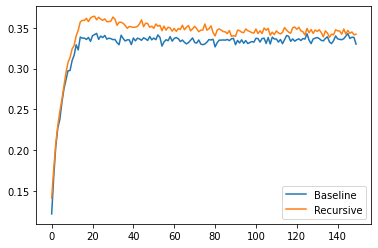

In [14]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(losslist_n))), losslist_n, label="Baseline")
plt.plot(list(range(len(losslist_r))), losslist_r, label="Recursive")
plt.legend()
plt.show()

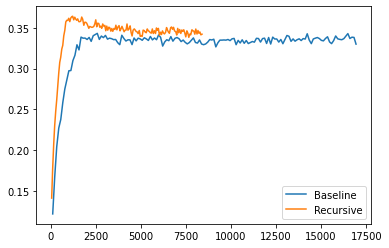

In [15]:
plt.plot(timelist_n, losslist_n, label="Baseline")
plt.plot(timelist_r, losslist_r, label="Recursive")
plt.legend()
plt.show()